### Unstructured Data Analysis for Policy (94-775)
### Final Project Report
### Hikaru Murase (hikarum), Nidhi Shree (nshree)
### May 3, 2018

## Part (1) Collecting Data of Image Files
* Note: If you download the data from Google Drive, you can skip this part (move to part (2)).

### (a) Bing Image Search (damaged and undamaged buildings)
First, we collected image files from Bing image search results using Web API (Bing Image Search API v7). The reason why we chose Bing instead of Google is that Google does not give us over 100 image files per keyword. The issue seems to remain unsolved. Although Bing provided us with more than 100 image files, the total number still did not reach 1,000. (Even we searched more popular words such as "cat" in this API, we could not obtain over 1,000 files.)  
  
In conclusion, we obatained approximately 300 pictures of damaged buildings and 500 pictures of undamaged buildings from Bing image search. In these files, most of the images appear to contain single building, while some images do not appear to contain buildings.  
  
Also, as a data augmentation process, we flipped the images horizontally and add the flipped images to the data. Thus, the volume of data doubled (damaged: 600, undamaged: 1,000 in total)  
  
* Note 1: Before running the code below, plase create a new folder (named "images") in the folder where this ipynb file exists. Then, create two new folders (named "damaged" and "undamaged", respectively) directly under "images" folder. Thus, the structure of the folders should be as follows: >base folder > "images" > "damaged" and "undamaged"
* Note 2: Downloaded image files should be stored in "damaged" folder for images of damaged buildings and "undamaged" folder for images of undamaged buildings. You need to transfer files downloaded by the code below to each folder ("damaged" or "undamaged") manually at the end of (a) and (b).
* Note 3: You need to run all the code in part (a) twice to obtain images of "undamaged" buildings and "damaged" buildings separately. The details are describred in the following code.

In [15]:
# This code is a preparation for using web API in Bing image search.
subscription_key = '859122352e0342e299ac923d58604c24' # This is my API key 
   # (The number of calls is limited to 1,000 per month.)

assert subscription_key
search_url = "https://api.cognitive.microsoft.com/bing/v7.0/images/search"

# You need to run all the code in part (a) twice to get two kinds of data. 
# (1) In the first time, assign search term as "single building."
# (2) In the second time (after you finish data augmentation for images of 'single building'),
# assign search term as "single collapsed building" 

search_term = "single building" # (1) to search images of undamaged buildings
#search_term = "Single collapsed building" # (2) to search images of damaged buildings

count = 150 # number of images to get per attempt (max: 150)

In [16]:
# This code will extract image files' thumbnail urls and encoding formats 
import requests

# 1st attempt of a loop process
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
params  = {"count": count, "q": search_term, "offset": 0, "license": "any", "imageType": "photo"}  
response = requests.get(search_url, headers=headers, params=params)
response.raise_for_status()
search_results = response.json() 

thumbnail_urls = []
content_urls = []
formats = []

for img in search_results["value"]:
    thumbnail_urls.append(img["thumbnailUrl"]) # extract and store the thumbnail URLS.
    content_urls.append(img["contentUrl"]) # extract and store the content URLS
    formats.append(img["encodingFormat"]) # extract and store the encoding formats

# the following code extracts total estimate matches.
total_num_files = search_results["totalEstimatedMatches"]

# the following code extracts the next offset ("The zero-based offset that indicates 
# the number of images to skip before returning images. The default is 0. 
# The offset should be less than (totalEstimatedMatches - count)")
offset = search_results["nextOffset"]

print("Total estimate matches (the number of images hit by the search term): ", total_num_files)
print("The next offset is", offset, ".")


while offset < total_num_files - count: 
    # Extract image files (2nd, 3rd, ..., and the last-1 attempt of the loop)
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"count": count, "q": search_term, "offset": offset, "license": "any", "imageType": "photo"}  
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    for img in search_results["value"]:
        thumbnail_urls.append(img["thumbnailUrl"])
        content_urls.append(img["contentUrl"])
        formats.append(img["encodingFormat"])
    offset = search_results["nextOffset"]
    print("The next offset is", offset, ".")
else: 
    count = total_num_files - offset - 1
    if count > 0: # Extract the remainig image files (the last attempt of the loop)
        headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
        params  = {"count": count, "q": search_term, "offset": offset, "license": "any", "imageType": "photo"}  
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_results = response.json()
        for img in search_results["value"]:
            thumbnail_urls.append(img["thumbnailUrl"])
            content_urls.append(img["contentUrl"])
            formats.append(img["encodingFormat"])
        offset = search_results["nextOffset"]
        print("The next offset is", offset, "(this is the end point).")
    print("The total number of images obtained:", len(thumbnail_urls))

Total estimate matches (the number of images hit by the search term):  609
The next offset is 187 .
The next offset is 371 .
The next offset is 565 .
The next offset is 642 (this is the end point).
The total number of images obtained: 491


In [17]:
# This code will download the images to the same folder as this ipynb file (this will take some minutes)
for i, url in enumerate(thumbnail_urls): # if you want to download thumbnail files choose this line
#for i, url in enumerate(content_urls): # if you want to download content (full size) files choose this line
    fileName = str(i+1) + "." +formats[i]
    req = requests.get(url)
    f = open(fileName, 'wb')
    f.write(req.content)
    f.close()
    
##### NOTE: #####
# To apply data augmentation below, you still need to keep downloaded files in the same folder as the folder containing your ipynb file.
# (Do not transfer downloaded files until you complete the data augmentation by the below code.)
# After data augmentation below code, you need to (create "undamaged" or "damaged" folder and) transfer these files into the folder manually.

As data augmentation, we flipped the images horizontally and add the flipped images to the data.

In [18]:
# This code will doncuct data augmentation (flip horizontally) for the downloaded files by above code.
from PIL import Image
from PIL import ImageOps

for i, url in enumerate(thumbnail_urls): # if you downloaded thumbnail files choose this line
#for i, url in enumerate(content_urls): # if you downloaded content (full size) files choose this line
    fileName = str(i+1) + "." +formats[i]
    fileName_mir = "mir_" + str(i+1) + "." +formats[i]
    img = Image.open(fileName)
    img_mir = ImageOps.mirror(img)
    if formats[i] == "jpg" or formats[i] == "jpeg" or formats[i] == "gif" or formats[i] == "png":
        # This is for the purpose of avoiding error due to irregular extention such as ".animatedgif"
        img_mir.save(fileName_mir)
    

* Note 1: After applying the code above, you will need to transfer these files into the specified folder ("damaged" or "undamaged") manually. 
* Note 2: Once you transfer the files, you can re-run the code to obtain images of damaged buildings by changing the search query. If you have run the code in part (a) twice (i.e. you have obtained images of both undamaged and damaged from Bing Image Search), you can move to part (b).

### (b) Natural Hazards Image Database (damaged buildings)
Second, we obtained images of damaged buildings from Natural Hazards Image Database where there are approximately 100 photos taken in the stricken areas by earthquakes such as the Great East Japan Earthquake in 2011. We used web scraping to obtain the data. In summary, we gained 83 images. As in part (a), we conducted data augmentation (flipped horizontally) to double the data. Therefore, we obtained 166 images of damaged buildings in total. While most images contain damaged (collapsed) buildings, some of the pictures contain several (not single) buildings and a few pictures do not appear to contain buildings.

In [1]:
import requests
import sys
from bs4 import BeautifulSoup as bs
import time

* Note:Before running the code below, make sure that you transferred image files downloaded in part (a) to the "undamaged" or "damaged" folders. 

In [23]:
# This code will extract urls of images from Natural Hazards Image Database by web scraping.

# You can extract 39 images of 2011 Honshu Japan Earthquake and Tsunami from the following code.
r1 = requests.get('https://www.ngdc.noaa.gov/hazardimages/event/show/256') 

# Extract 24 pictures of 2011 Christchurch New Zealand Earthquake
r2 = requests.get('https://www.ngdc.noaa.gov/hazardimages/event/show/259') 

# Extract 20 pictures of 2010 Haiti Earthquake and Tsunami
r3 = requests.get('https://www.ngdc.noaa.gov/hazardimages/event/show/258') 

links = []
for i in [1,2,3]:
    page = eval("r"+str(i)).content
    soup = bs(page, "html.parser")
    lists = soup.find_all("li", class_ = "")
    for list_ in lists:
        link = list_.img.get("src")
        links.append(link)

In [24]:
# This code will download the pictures urls of which are stored in "lists"
for link in links:
    fileName = link.split("/")[-1]
    req = requests.get(link)
    f = open(fileName, 'wb')
    f.write(req.content)
    f.close()

##### NOTE #####
# To apply data augmentation below, you still need to keep downloaded files in the same folder as the folder containing your ipynb file.
# (Do not transfer downloaded files until you complete the data augmentation by the below code.)
# After data augmentation below code, you need to transfer these files into the "damaged" folder manually.

In [25]:
#This code will conduct data augmentation (flip horizontally) 
for link in links:
    fileName = link.split("/")[-1]
    fileName_mir = "mir_" + link.split("/")[-1]
    img = Image.open(fileName)
    img_mir = ImageOps.mirror(img)
    img_mir.save(fileName_mir)


* Note: After downloading, you will need to transfer these files into the "damaged" folder manually.

### (c) Other Sources
Finally, we acquired image data of undamaged buildings from The Oxford Building Dataset, which offers approximately 5,000 pictures collected from Flickr by searching for particular Oxford landmarks; however, many of the images are pictures of humans or pictures taken inside buildings. Thus, we decided not use this data.

#### Reference List
- Microsoft Azure, "Image Search API v7 reference", https://docs.microsoft.com/en-us/rest/api/cognitiveservices/bing-images-api-v7-reference
- "Do you know why only 100 images is the limit? Can we have more than 100?", https://github.com/hardikvasa/google-images-download/issues/7
- "ImageOps Module" http://pillow.readthedocs.io/en/latest/reference/ImageOps.html#PIL.ImageOps.mirror
- "Natural Hazards Image Database", https://www.ngdc.noaa.gov/hazardimages/
- "Do you know why only 100 images is the limit? Can we have more than 100?", https://github.com/hardikvasa/google-images-download/issues/7
- James Philbin, Relja Arandjelović and Andrew Zisserman, "The Oxford Buildings Dataset", http://www.robots.ox.ac.uk/~vgg/data/oxbuildings/

## Part (2) Image Analysis (Establishing Models)
Using the collected images (763 image files of damaged buildings and 1,160 image files of undamaged buildings), we conducted image analysis to establish classifiers which can classify "damaged" and "undamaged" buildings.  
  
First, we resized images and flattened them to make it easier to analyze. We labeled each image as "damaged" (y = 1) or "undamaged" (y = 0).  
  
Second, we divided the images into a training set and a test set randomly.  
  
Third, we conducted Principal Component Analysis (PCA) to reduce dimensions of image features. As the code below demonstrates, the first six principal components explain the variance well. Thus, we chose the number of components as six.  
  
Fourth, since this is a classification problem, we used Support Vector Machine (SVM) classifier, k-Nearest Neighbor (k-NN), Random Forest (RM) classifier, and neural network (NN) as classifiers. For SVM, k-NN, and RM, we performed 10-fold cross-validation to choose the best hyperparameter (C for SVM classifier, k for k-NN, and the number of trees (b) for RM classifier). Regarding neural network, we tried a single layer neural net, a two-layer neural net, and a two-layer neural net without dimension reduction.    
  
Finally, we evaluated the models with the best hyperparameters by computing a test error rate or accuracy and created a confusion matrix for each model for part (3).  

In [45]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import pylab as pl
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import glob
# You need to install "keras" and "tensorflow" packages in your Python to run this code.
from keras.utils import to_categorical
from keras import models
from keras import layers

In [46]:
# This code will create functions to transform images

# Define the size after resizing
standard_size = (300, 167)

# Resize an image to the standard_size (shape = (167, 300, 3))
# and convert it numpy array of RGB pixels
def img_to_matrix(filename):
    img = Image.open(filename)
    img = img.resize(standard_size)
    img_array = np.array(img)
    return img_array

# Flatten a (m, n, l) numpy array into an array of shape (1, m * n * l)
def flatten_image(img):
    if len(img.shape)==3: # To avoid an error due to a few narray with an exceptional shape (m, n)
            s = img.shape[0] * img.shape[1] * img.shape[2]
            img_wide = img.reshape(1, s)
            return img_wide[0] 

In [47]:
# This code will list each image files within "damaged" and "undamaged" folders in "image" folder 
# and label "damaged" to the files in "damaged" folder and "undamaged" to the files in "undamaged" folder 
images = []
labels = []

for image in glob.glob("./images/damaged/*.jpg"):
    images.append(image)
    labels.append("damaged")
for image in glob.glob("./images/damaged/*.jpeg"):
    images.append(image)
    labels.append("damaged")
for image in glob.glob("./images/damaged/*.gif"):
    images.append(image)
    labels.append("damaged")
for image in glob.glob("./images/damaged/*.png"):
    images.append(image)
    labels.append("damaged")
      
for image in glob.glob("./images/undamaged/*.jpg"):
    images.append(image)
    labels.append("undamaged")
for image in glob.glob("./images/undamaged/*.jpeg"):
    images.append(image)
    labels.append("undamaged")
for image in glob.glob("./images/undamaged/*.gif"):
    images.append(image)
    labels.append("undamaged")
for image in glob.glob("./images/undamaged/*.png"):
    images.append(image)
    labels.append("undamaged")

In [48]:
# This code will create a function to process the data (convert image files into a numpy array)
def data_processing(images, labels):         
    data = []
    
    del_row = []
    for i, image in enumerate(images):
        # Apply the created functions above
        img = img_to_matrix(image)
        img = flatten_image(img)
        
        if img is not None: # To remove null row (the image whose shape was not (m, n, l) numpy array)
            data.append(img)
        if img is None:
            del_row.append(i)

    # Convert "data" list into numpy array
    data = np.array(data)

    # Remove the corresponding rows from "labels"
    labels = np.delete(labels, del_row, axis = 0)
    print("Images in row #", del_row, "were removed due to the irregular shape.")
    return data, labels

In [5]:
# This code will print the variance ratio explained by each principle component.
# We can check the explained variance ratio by PCA to determine the number of principal components.
data, cleaned_labels = data_processing(images, labels)
pca = PCA()
pca.fit(data)
pca.explained_variance_ratio_[:20] # display only the first ten (20) principal components

Images in row # [722, 723, 724, 725] were removed due to the irregular shape.


array([0.19880338, 0.0942502 , 0.05668722, 0.04152947, 0.03914788,
       0.02474766, 0.02014306, 0.0161251 , 0.01382254, 0.0136698 ,
       0.01188621, 0.01024629, 0.00867681, 0.00847302, 0.00776684,
       0.00703954, 0.00673103, 0.00659129, 0.00557721, 0.00556092])

The result above shows that the first principal component explains 19.9%, the second explains 9.4%, the third explains 5.7%, the fourth explains 4.2%, the fifth explains 2.5%, and the sixthe explains 2.0% of the variance. Thus, we chose the number of components as six (6).  
  
Then, we labeled each image as "damaged" (y = 1) or "undamaged" (y = 0), divided the images into a training set and a test set randomly, and conducted Principal Component Analysis (PCA) to reduce dimensions of image features. 

In [49]:
# This code will divide data into a training set and a test set randomly, 
# then conduct dimensionality reduction with PCA (dimension will reduce from 150300 to 6)

data, new_labels = data_processing(images, labels)
y = np.where(np.array(new_labels) == 'damaged', 1, 0) # Labeleach image as "damaged" (y = 1) and "undamaged" (y = 0)
np.random.seed(94774)
random_ordering_of_data = np.random.permutation(len(data))
train_frac = 0.80 # Define the ratio of training data as 80% of the entire data
num_training_data = int(train_frac * len(data))
train_indices = random_ordering_of_data[:num_training_data]
test_indices = random_ordering_of_data[num_training_data:]
train_x = data[train_indices]
train_y = y[train_indices]
test_x = data[test_indices]
test_y = y[test_indices]

print("The number of images of damaged buildings in total:", len(y[y==1]))
print("The number of images of undamaged buildings in total:", len(y[y==0]))
      
print("The number of training samples:", len(train_y))
print("The number of images of damaged buildings in the training samples:", len(train_y[train_y==1]))
print("The number of images of undamaged buildings in the training samples:", len(train_y[train_y==0]))

print("The number of test samples:", len(test_y))
print("The number of images of damaged buildings in the test samples:", len(test_y[test_y==1]))
print("The number of images of undamaged buildings in the test samples:", len(test_y[test_y==0]))

## Reduce demension to 6 principal components
pca = PCA(n_components = 6)
train_x = pca.fit_transform(train_x)
test_x = pca.fit_transform(test_x)

Images in row # [722, 723, 724, 725] were removed due to the irregular shape.
The number of images of damaged buildings in total: 756
The number of images of undamaged buildings in total: 1154
The number of training samples: 1528
The number of images of damaged buildings in the training samples: 593
The number of images of undamaged buildings in the training samples: 935
The number of test samples: 382
The number of images of damaged buildings in the test samples: 163
The number of images of undamaged buildings in the test samples: 219


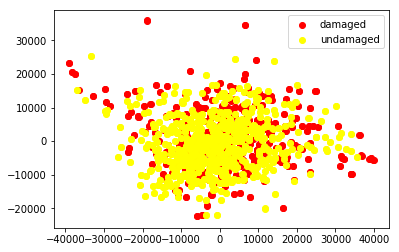

In [7]:
## This code will plot the 1st and 2nd principle components.
pca = PCA(n_components=2)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label": np.where(y == 1, 'damaged', 'undamaged')})
colors = ['red', 'yellow']
for label, color in zip(df['label'].unique(), colors):
    mask = df['label'] == label
    pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
pl.legend()

According to the plot above, it appears that there is no large difference of the first and the second components between damaged buildings and undamaged buildings. 

### (1) Support Vector Machine (SVM) classifier  
First, we conducted 10-fold cross-validation in the training dataset to choose the best C for the SVM classifier.  
Then, we fitted the model with the best hyperparameter to the entire training dataset and evaluated the model in the unseen test set.

In [50]:
# This code will create a function to conduct cross-validation to choose the best hyperparameter.
def CV_SVC(train_x, train_y):
    lowest_cross_val_error = np.inf
    best_C = None
    indices = range(len(train_x))
    kf = KFold(n_splits=10, random_state=94775)

    for C in [1e-2, 1e-1, 1, 10, 100, 1000]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = LinearSVC(C=C, random_state=94775)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('C:', C, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_C = C

    print('Best C:', best_C, 'cross validation error:', lowest_cross_val_error)
    return best_C

In [51]:
# This code will fit the model with the best hyperparameter to the train set
# and evaluate the best SVM classifier in the test set

# Apply the function above to assign the best hyperparameter
best_C = CV_SVC(train_x, train_y)

# Fit the classifier with the best C to the "entire" training set
final_svm_classifier = LinearSVC(C=best_C, random_state=94775)
final_svm_classifier.fit(train_x, train_y)

# Evaluate the model in the "unseen" test set
predicted_test_labels = final_svm_classifier.predict(test_x)
test_set_error = np.mean(predicted_test_labels != test_y)
print("Test_set_error of SVM classifier with the best C:", test_set_error)

# Create a confusion matrix
print("The confusion matrix is as follows:")
cm_svc = pd.crosstab(test_y, predicted_test_labels, rownames=['Actual'], colnames=['Predicted'])
cm_svc

C: 0.01 cross validation error: 0.48630460956312344
C: 0.1 cross validation error: 0.4856510147918816
C: 1 cross validation error: 0.4856510147918816
C: 10 cross validation error: 0.4856510147918816
C: 100 cross validation error: 0.4856510147918816
C: 1000 cross validation error: 0.4856510147918816
Best C: 0.1 cross validation error: 0.4856510147918816
Test_set_error of SVM classifier with the best C: 0.5052356020942408
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,105,114
1,79,84


As a result, the the best hyperperameter for a SVM classifier is 0.1 (C = 0.1), and the test set error of the best SVM classifier is 50.5% (accuracy is 49.5%).

### (2) k-Nearest Neighbor (k-NN) 
First, we conducted 10-fold cross-validation in the training dataset to choose the best k for the k-Nearest Neighbor.  
Then, we fitted the model with the best hyperparameter to the entire training dataset and evaluated the model in the unseen test set.

In [52]:
# This code will create a function to conduct cross-validation to choose the best hyperparameter.
def CV_kNN(train_x, train_y):
    lowest_cross_val_error = np.inf
    best_k = None
    indices = range(len(train_x))
#    kf = KFold(n_splits=10, shuffle=True, random_state=94775)
    kf = KFold(n_splits=10, random_state=94775)
    for k in [3, 5, 15, 25, 50]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = KNeighborsClassifier(n_neighbors=k)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('k:', k, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_k = k

    print('Best k:', best_k, 'cross validation error:', lowest_cross_val_error)
    return best_k

In [53]:
# This code will fit the model with the best hyperparameter to the train set
# and evaluate the best SVM classifier in the test set

# Apply the function above to assign the best hyperparameter
best_k = CV_kNN(train_x, train_y)

# Fit the classifier with the best hyperparameter to the "entire" training set
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
final_knn_classifier.fit(train_x, train_y)

# Evaluate the model in the "unseen" test set
predicted_test_labels = final_knn_classifier.predict(test_x)
test_set_error = np.mean(predicted_test_labels != test_y)
print("Test_set_error of k-Nearest Neighbor with the best k:", test_set_error)

# Create a confusion matrix
print("The confusion matrix is as follows:")
cm_knn = pd.crosstab(test_y, predicted_test_labels, rownames=['Actual'], colnames=['Predicted'])
cm_knn

k: 3 cross validation error: 0.3619754041967664
k: 5 cross validation error: 0.33384072927416575
k: 15 cross validation error: 0.3652476780185759
k: 25 cross validation error: 0.38161764705882356
k: 50 cross validation error: 0.38095115239078087
Best k: 5 cross validation error: 0.33384072927416575
Test_set_error of k-Nearest Neighbor with the best k: 0.306282722513089
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,180,39
1,78,85


As a result, the the best hyperperameter for a k-Nearest Neighbor is 5 (k = 5), and the test set error of the best SVM classifier is 30.6% (accuracy is 69.4%).

### (3) Random Forest classifier (RF) 
First, we conducted 10-fold cross-validation in the training dataset to choose the best b (number of trees) for the Random Forest classifier.  
Then, we fitted the model with the best hyperparameter to the entire training dataset and evaluated the model in the unseen test set.

In [54]:
# This code will create a function to conduct cross-validation to choose the best hyperparameter.
def CV_RF(train_x, train_y):
    lowest_cross_val_error = np.inf
    best_b = None
    indices = range(len(train_x))
    kf = KFold(n_splits=10, shuffle=True, random_state=94775)
    for b in [50, 100, 150, 200, 250]:
        errors = []
        for train_indices, val_indices in kf.split(indices):
            classifier = RandomForestClassifier(n_estimators=b, random_state=94775)
            classifier.fit(train_x[train_indices], train_y[train_indices])
            predicted_val_labels = classifier.predict(train_x[val_indices])
            error = np.mean(predicted_val_labels != train_y[val_indices])
            errors.append(error)
        
        cross_val_error = np.mean(errors)
        print('b:', b, 'cross validation error:', cross_val_error)

        if cross_val_error < lowest_cross_val_error:
            lowest_cross_val_error = cross_val_error
            best_b = b

    print('Best b:', best_b, 'cross validation error:', lowest_cross_val_error)
    return best_b

In [55]:
# This code will fit the model with the best hyperparameter to the train set
# and evaluate the best SVM classifier in the test set

# Apply the function above to assign the best hyperparameter
best_b = CV_RF(train_x, train_y)

# Fit a classifier with the best b to the "entire" training set
final_rf_classifier = RandomForestClassifier(n_estimators=best_b, random_state=94775)
final_rf_classifier.fit(train_x, train_y)

# Evaluate the model in the "unseen" test set
predicted_test_labels = final_rf_classifier.predict(test_x)
test_set_error = np.mean(predicted_test_labels != test_y)
print("Test_set_error of Random Forest with the best b:", test_set_error)

# Create a confusion matrix
print("The confusion matrix is as follows:")
cm_rf = pd.crosstab(test_y, predicted_test_labels, rownames=['Actual'], colnames=['Predicted'])
cm_rf

b: 50 cross validation error: 0.22705108359133125
b: 100 cross validation error: 0.21788785689714482
b: 150 cross validation error: 0.21658926728586173
b: 200 cross validation error: 0.21526487788097698
b: 250 cross validation error: 0.21526917784657726
Best b: 200 cross validation error: 0.21526487788097698
Test_set_error of Random Forest with the best b: 0.3298429319371728
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,190,29
1,97,66


As a result, the the best hyperperameter for a Random Forest classifier is 200 (b = 200), and the test set error of the best SVM classifier is 33.0% (accuracy is 67.0%).

### (4) Neural network (NN) 
First, we .  
Then, 

#### (a) Single-layer neural net
We...

In [29]:
# This code will...
#code to apply neural nets
from keras.utils import to_categorical
train_labels_categorical = to_categorical(train_y)
test_labels_categorical = to_categorical(test_y)

In [30]:
train_x[0]

array([ -816.26016965,  8079.45356229,  3492.83630898,  -672.21957669,
       -4377.6510817 ,  2665.30219031])

In [31]:
train_labels_categorical[0]

array([0., 1.], dtype=float32)

In [32]:
print(train_x.shape)

(1528, 6)


In [33]:
# This code will...
from keras import models
from keras import layers

shallow_single_layer_mod = models.Sequential()  # this is Keras's way of specifying a model that is a single sequence of layers
shallow_single_layer_mod.add(layers.Dense(2, activation='softmax', input_shape=(6,))) #since it is a 2 class classifier, therefore 2

# the line below is not required for constructing the model and just gives a summary of the model
print(shallow_single_layer_mod.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# This code will...

# the lecture slides explains the loss (which is an error function) that the optimizer will try to minimize;
# there are some optimizers that are popularly used for training neural nets such as stochastic gradient
# descent (SGD), RMSProp, and Adam (for the purposes of this class, don't worry about what these are)
shallow_single_layer_mod.compile(optimizer='rmsprop',
                                   loss='categorical_crossentropy',
                                   metrics=['accuracy'])  # metrics says what accuracy metrics to display when training

In [35]:
# This code will...

shallow_single_layer_mod.fit(train_x,
                               train_labels_categorical,
                               validation_split=0.2,
                               epochs=5,
                               batch_size=128)

Train on 1222 samples, validate on 306 samples
Epoch 1/5
1222/1222 [==============================] - 0s 260us/step - loss: 8.9376 - acc: 0.4452 - val_loss: 8.9018 - val_acc: 0.4477
Epoch 2/5
1222/1222 [==============================] - 0s 24us/step - loss: 8.9608 - acc: 0.4435 - val_loss: 8.9018 - val_acc: 0.4477
Epoch 3/5
1222/1222 [==============================] - 0s 21us/step - loss: 8.9571 - acc: 0.4435 - val_loss: 8.9354 - val_acc: 0.4444
Epoch 4/5
1222/1222 [==============================] - 0s 28us/step - loss: 8.9398 - acc: 0.4452 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 5/5
1222/1222 [==============================] - 0s 30us/step - loss: 8.9624 - acc: 0.4435 - val_loss: 8.9623 - val_acc: 0.4412


In [36]:
# This code will...
test_loss, test_acc = shallow_single_layer_mod.evaluate(test_x,
                                                          test_labels_categorical)
print('Test accuracy:', test_acc)

382/382 [==============================] - 0s 38us/step
Test accuracy: 0.41099476658236916


#### (b) 2-layer neural net
We...

In [37]:
# This code will...
two_layer_model = models.Sequential()  # this is Keras's way of specifying a model that is a single sequence of layers
two_layer_model.add(layers.Dense(250, activation='relu', input_shape=(6,))) #optimized to get best accuracy at 250
two_layer_model.add(layers.Dense(2, activation='softmax'))

print(two_layer_model.summary())


two_layer_model.compile(optimizer='rmsprop',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 250)               1750      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 502       
Total params: 2,252
Trainable params: 2,252
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# This code will...
two_layer_model.fit(train_x,
                    train_labels_categorical,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=128)

Train on 1222 samples, validate on 306 samples
Epoch 1/5
1222/1222 [==============================] - 0s 299us/step - loss: 9.2544 - acc: 0.4255 - val_loss: 9.1563 - val_acc: 0.4281
Epoch 2/5
1222/1222 [==============================] - 0s 20us/step - loss: 8.6483 - acc: 0.4624 - val_loss: 8.6627 - val_acc: 0.4608
Epoch 3/5
1222/1222 [==============================] - 0s 22us/step - loss: 8.1620 - acc: 0.4918 - val_loss: 8.9018 - val_acc: 0.4477
Epoch 4/5
1222/1222 [==============================] - 0s 32us/step - loss: 7.8322 - acc: 0.5123 - val_loss: 7.1544 - val_acc: 0.5556
Epoch 5/5
1222/1222 [==============================] - 0s 33us/step - loss: 6.7825 - acc: 0.5786 - val_loss: 7.3639 - val_acc: 0.5425


In [39]:
# This code will...
test_loss, test_acc = two_layer_model.evaluate(test_x, test_labels_categorical)
print('Test accuracy:', test_acc)

382/382 [==============================] - 0s 44us/step
Test accuracy: 0.5890052374744914


In [40]:
# This code will...
#predicted_test_labels = shallow_single_layer_mod.predict(test_x)  # if the performance of the single layer model is better, use this line
predicted_test_labels = two_layer_model.predict(test_x) # if the performance of the two layer model is better, use this line

predict_y= []
for row in predicted_test_labels:
    if row[0] < row[1]:
        predict_y.append(1)
    else:
        predict_y.append(0)
    
#predicted_test_y = np.where(np.array(predicted_test_labels) == [0,1], 1, 0)
print(type(test_y))
#test_set_error = np.mean(predicted_test_labels != test_y)
#print("Test_set_error of Random Forest with the best b:", test_set_error)
# Create a confusion matrix#
print("The confusion matrix is as follows:")
cm_nn = pd.crosstab(test_y, np.array(predict_y), rownames=['Actual'], colnames=['Predicted'])
cm_nn

<class 'numpy.ndarray'>
The confusion matrix is as follows:


Predicted,0,1
Actual,,
0,110,109
1,48,115


#### (c) 2-layer neural net without dimensional reduction
We also tried neural network without dimensional reduction (we used data before conducting PCA).

In [15]:
# This code will redefine training and test data  
train_x_original = data[train_indices]
train_y_original = y[train_indices]
test_x_original = data[test_indices]
test_y_original = y[test_indices]

train_labels_categorical_original = to_categorical(train_y_original)
test_labels_categorical_original = to_categorical(test_y_original)

train_x_original.shape

(1528, 150300)

In [17]:
# This code will specify a model
two_layer_model = models.Sequential()  # this is Keras's way of specifying a model that is a single sequence of layers
two_layer_model.add(layers.Dense(250, activation='relu', input_shape=(150300,))) #optimized to get best accuracy at 250
two_layer_model.add(layers.Dense(2, activation='softmax'))

two_layer_model.compile(optimizer='rmsprop',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [18]:
# This code will fit the neural net to the training set.
two_layer_model.fit(train_x_original,
                    train_labels_categorical_original,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=128)

Train on 1222 samples, validate on 306 samples
Epoch 1/5
1222/1222 [==============================] - 17s 14ms/step - loss: 6.2520 - acc: 0.6121 - val_loss: 6.2681 - val_acc: 0.6111
Epoch 2/5
1222/1222 [==============================] - 14s 12ms/step - loss: 6.2520 - acc: 0.6121 - val_loss: 6.2681 - val_acc: 0.6111
Epoch 3/5
1222/1222 [==============================] - 14s 12ms/step - loss: 6.2520 - acc: 0.6121 - val_loss: 6.2681 - val_acc: 0.6111
Epoch 4/5
1222/1222 [==============================] - 14s 12ms/step - loss: 6.2520 - acc: 0.6121 - val_loss: 6.2681 - val_acc: 0.6111
Epoch 5/5
1222/1222 [==============================] - 14s 11ms/step - loss: 6.2520 - acc: 0.6121 - val_loss: 6.2681 - val_acc: 0.6111


In [19]:
# This code will compute test accuracy of the model.
test_loss_original, test_acc_original = two_layer_model.evaluate(test_x_original, test_labels_categorical_original)
print('Test accuracy:', test_acc_original)

382/382 [==============================] - 1s 4ms/step
Test accuracy: 0.5732984290073055


As a result, the test accuracy of 2-layer neural net without dimensional reduction is 57.3%.

In summary, 2-layer neural network with dimensional reduction perform the best.

## Part (3) Selecting the Best Classifier (Performance Evaluation)
We evaluated the models with the best hyperparameters by comparing the expected cost (pay-off) of each model as follows.
  
First, we constructed a Cost Preference Matrix with points allotted to all outcomes (TP, TN, FP, FN) in a confusion matrix.  
In the matrix, we penalized more where actual condition of building is "damaged" but classified as "undamaged" (FN). This is because government officials might overlook the intensity of damage.  
  
After constructing the matrix, we computed the expected costs (pay-off) of each classifier to select the best classifier, using a cost preference matrix and the confusion matrixes derived from each classifier.

In [44]:
# This code will create a cost preference matrix
import pandas as pd

# Creates a list containing 2 lists, each of 2 items, all set to 0
w, h = 2, 2;
cost_matrix = [[0 for x in range(w)] for y in range(h)] 

cost_matrix[0][0] = 10
cost_matrix[0][1] = 5*(-1) 
cost_matrix[1][0] = 10*(-1)
cost_matrix[1][1] = 10

df = pd.DataFrame(cost_matrix)
df

,0,1
0,10,-5
1,-10,10


In [42]:
# This code will define a function to sum up all the elements in a matrix.
def get_sum_elements(arr):
    sum_array = 0
    for row in range(len(arr)):
        for col in range(len(arr[row])):
            sum_array = sum_array+ arr[row][col]
        
    return sum_array

In [43]:
# This code will calculate the expected cost (pay-off) for each model
cost = []
cost.append(get_sum_elements(cm_svc * df))
cost.append(get_sum_elements(cm_knn * df))
cost.append(get_sum_elements(cm_rf * df))
cost.append(get_sum_elements(cm_nn * df))
cost

[530, 1675, 1445, 1225]

According to the result, (k-NN's pay-off is the highest)  
    
In conclusion, (k-NN is the best classifier)
  
The reason why k-Nearest Neighbor was the best might be...
  
Through industry experience we know that Neural Network is the state-of-art machine learning technique for accurate image analysis; however,... (challenges explained)

#### Reference List
- yhat, "Content-based image classification in Python", June 12, 2013, http://blog.yhat.com/posts/image-classification-in-Python.html